In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 50)

import os
# Use this to see how much memory the dataframes use
from sys import getsizeof

import pseudopeople as pp

from vivarium_research_prl.utils import sizemb, MappingViaAttributes
from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data

!date
!whoami
!uname -a
!pwd

Tue 28 Mar 2023 10:11:48 PM PDT
ndbs
Linux int-slurm-sarchive-p0005 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/noise


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
project_output_dir = \
    '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
output_subdir = (
    'results/vv_tax_observers'
    '/united_states_of_america/2023_03_06_12_42_55'
    '/final_results/2023_03_14_16_41_22'
)
output_dir = f'{project_output_dir}/{output_subdir}'

!ls -halt $output_dir

total 14G
drwxrwsr-x  2 albrja IHME-Simulationscience 4.0K Mar 22 16:44 .
-rw-r--r--  1 albrja IHME-Simulationscience  59M Mar 15 10:01 wic_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 1.5G Mar 15 10:01 tax_dependents_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.8G Mar 15 09:57 tax_w2_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 4.1G Mar 15 09:56 tax_1040_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 192M Mar 15 09:48 social_security_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience  35M Mar 15 09:36 household_survey_observer_cps.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.7M Mar 15 09:36 household_survey_observer_acs.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 638M Mar 15 09:36 decennial_census_observer.csv.bz2
drwxrwsr-x 12 albrja IHME-Simulationscience 5.5K Mar 14 20:25 ..


# Load WIC data for testing

In [4]:
%%time
df_wic = pd.read_csv(f'{output_dir}/wic_observer.csv.bz2')
print(sizemb(df_wic), 'MB')
df_wic

1629.922531 MB
CPU times: user 15.2 s, sys: 530 ms, total: 15.8 s
Wall time: 15.8 s


,wic_year,middle_initial,household_id,zipcode,housing_type,simulant_id,guardian_1,race_ethnicity,date_of_birth,last_name,first_name,age,street_name,city,guardian_2,relation_to_household_head,sex,unit_number,street_number,state
0,2021,L,2284_334371,83801.0,Standard,2284_30,2284_-1,White,1990-04-11,Potts,Megan,30.663225,fire twr rd,hauser,2284_-1,Other nonrelative,Female,NaN,19461,ID
1,2021,B,2284_100,70570.0,Standard,2284_246,2284_-1,Black,1995-03-14,Luchin,Lily,25.740170,illinois dr,baker,2284_-1,Reference person,Female,NaN,821,LA
2,2021,B,2284_119,63121.0,Standard,2284_302,2284_-1,Black,1994-03-22,Eaton,Lexi,26.718624,cottage street,saint louis,2284_-1,Reference person,Female,NaN,4035,MO
3,2021,A,2284_280,2125.0,Standard,2284_677,2284_-1,White,1987-03-16,Rembold,Chelsey,33.736627,so normandy ave,worcester,2284_-1,Reference person,Female,NaN,330,MA
4,2021,J,2284_341,29212.0,Standard,2284_826,2284_-1,Black,1987-09-20,Billips,Amanda,33.219939,west jarlath street,clover,2284_-1,Other nonrelative,Female,NaN,35,SC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490390,2030,F,7359_398744,97212.0,Standard,7359_1174197,7359_682161,White,2030-01-10,Roth,Joel,0.037815,southwest 31st avenue,portland,7359_-1,Other nonrelative,Male,NaN,30,OR
1490391,2030,J,7359_474422,90631.0,Standard,7359_1174200,7359_758995,White,2030-01-01,Hager,Adalynn,0.061681,rue bayou,fresno,7359_-1,Biological child,Female,NaN,1011,CA
1490392,2030,K,7359_588502,98626.0,Standard,7359_1174202,7359_836404,White,2030-01-13,Hefley,Adriel,0.028668,iroquois ln,maple valley,7359_-1,Biological child,Male,NaN,1053,WA
1490393,2030,A,7359_363411,46703.0,Standard,7359_1174206,7359_904239,White,2030-01-08,Guimaraes,Paisley,0.042291,freeman rd,noblesville,7359_-1,Grandchild,Female,NaN,6631,IN


# Define some parameters

In [6]:
prob = 0.3
seed = 12

# Get first names for testing noise functions

In [5]:
first_names = df_wic.first_name
first_names

0            Megan
1             Lily
2             Lexi
3          Chelsey
4           Amanda
            ...   
1490390       Joel
1490391    Adalynn
1490392     Adriel
1490393    Paisley
1490394       Mila
Name: first_name, Length: 1490395, dtype: object

# Time using scalar function with `.map`

In [9]:
%time first_names_ocr_map = first_names.map(lambda s: corruption.ocr_corrupt(s, prob, seed))
first_names_ocr_map

CPU times: user 1min 21s, sys: 81 ms, total: 1min 21s
Wall time: 1min 21s


0            Meqan
1             L:|v
2             Lex:
3          Cbelsev
4           4manda
            ...   
1490390       Joe|
1490391    4dalvnn
1490392    4dr'leJ
1490393    Pa:s|ev
1490394       M:|a
Name: first_name, Length: 1490395, dtype: object

# Time using scalar function with `np.vectorize`

In [10]:
%time first_names_ocr_vec = np.vectorize(corruption.ocr_corrupt)(first_names, prob, seed)
first_names_ocr_vec

CPU times: user 1min 21s, sys: 102 ms, total: 1min 21s
Wall time: 1min 21s


array(['Meqan', 'L:|v', 'Lex:', ..., "4dr'leJ", 'Pa:s|ev', 'M:|a'],
      dtype='<U14')

In [11]:
pd.Series(first_names_ocr_vec) # Looks the same as using .map

0            Meqan
1             L:|v
2             Lex:
3          Cbelsev
4           4manda
            ...   
1490390       Joe|
1490391    4dalvnn
1490392    4dr'leJ
1490393    Pa:s|ev
1490394       M:|a
Length: 1490395, dtype: object

In [13]:
(first_names_ocr_map == first_names_ocr_vec).all()

True

# Time using vectorized version

In [14]:
%time first_names_ocr = corruption.ocr_corrupt(first_names, prob, seed)
first_names_ocr

CPU times: user 25.7 s, sys: 1.02 s, total: 26.7 s
Wall time: 26.7 s


0            Megan
1             L:ly
2             Lex:
3          Che1sey
4           4manda
            ...   
1490390       Joel
1490391    Adalynn
1490392     Adniel
1490393    PaisJev
1490394       Mila
Name: first_name, Length: 1490395, dtype: object

In [15]:
(first_names_ocr_map == first_names_ocr).sum()

328327

# Compare lengths of original to lengths of noised versions

In [7]:
%time first_names.str.len().mean()

CPU times: user 327 ms, sys: 4.24 ms, total: 331 ms
Wall time: 329 ms


5.917372240245036

In [17]:
first_names_ocr_map.str.len().mean()

6.0818682295633035

In [16]:
first_names_ocr.str.len().mean()

6.033894370284388

# See how many strings changed in each version

In [18]:
(first_names == first_names_ocr_map).sum()

145066

In [19]:
(first_names == first_names_ocr).sum()

707444

In [20]:
(first_names_ocr_map == first_names_ocr).sum()

328327

# Very rough estimate of how many strings we expect to change

Prob(token changes) = prob = 0.3

Prob(token doesn't change) = 1-prob = 0.7

Prob(1st 2 tokens don't change) = (1-prob)^2 = 0.7^2

Prob(no tokens change) = (1-prob)^(length of string)

Prob(some token changes) = 1 - (1-prob)^(length of string)

In [26]:
(1 - prob)**first_names.map(len)

0          0.168070
1          0.240100
2          0.240100
3          0.082354
4          0.117649
             ...   
1490390    0.240100
1490391    0.082354
1490392    0.117649
1490393    0.082354
1490394    0.240100
Name: first_name, Length: 1490395, dtype: float64

In [29]:
# Very rough estimated fraction of strings that stay the same
((1 - prob)**first_names.map(len)).mean()

0.1372013246133917

In [30]:
(1 - prob)**(first_names.map(len).mean())

0.12116786120900093

In [31]:
(((1 - prob)**first_names.map(len)).mean()) * len(first_names)

204484.16819717595

# Count number of OCR tokens in each string

In [36]:
%%time
counts = {}
for token in corruption.ocr_error_dict.keys():
    counts[token] = first_names.str.contains(token)
counts_df = pd.concat(counts, axis=1)
counts_df

CPU times: user 11.3 s, sys: 12.9 ms, total: 11.3 s
Wall time: 11.3 s


,0,1,12,13,17,1<,1>,2,5,6,...,l<,l>,lJ,lo,m,q,ri,u,w,y
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490390,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1490391,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1490392,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1490393,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [38]:
token_counts = counts_df.sum(axis=1)
token_counts

0          1
1          3
2          1
3          3
4          2
          ..
1490390    1
1490391    3
1490392    4
1490393    3
1490394    2
Length: 1490395, dtype: int64

In [39]:
token_counts.describe()

count    1.490395e+06
mean     1.905926e+00
std      1.138006e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      6.000000e+00
dtype: float64

# Get better estimate of how many strings we expect to stay the same -- this should be a lower bound of the probability that each string remains unchanged

In [41]:
min_prob_unchanged = (1 - prob)**token_counts
min_prob_unchanged

0          0.7000
1          0.3430
2          0.7000
3          0.3430
4          0.4900
            ...  
1490390    0.7000
1490391    0.3430
1490392    0.2401
1490393    0.3430
1490394    0.4900
Length: 1490395, dtype: float64

In [54]:
max_prob_changed = 1-min_prob_unchanged
max_prob_changed

0          0.3000
1          0.6570
2          0.3000
3          0.6570
4          0.5100
            ...  
1490390    0.3000
1490391    0.6570
1490392    0.7599
1490393    0.6570
1490394    0.5100
Length: 1490395, dtype: float64

In [42]:
min_prob_unchanged.mean()

0.5481159670691321

In [55]:
min_prob_unchanged.sum()

816909.2967399992

In [48]:
min_prob_unchanged.mean() * len(first_names)

816909.2967399992

In [56]:
max_prob_changed.sum()

673485.7032600007

<AxesSubplot: >

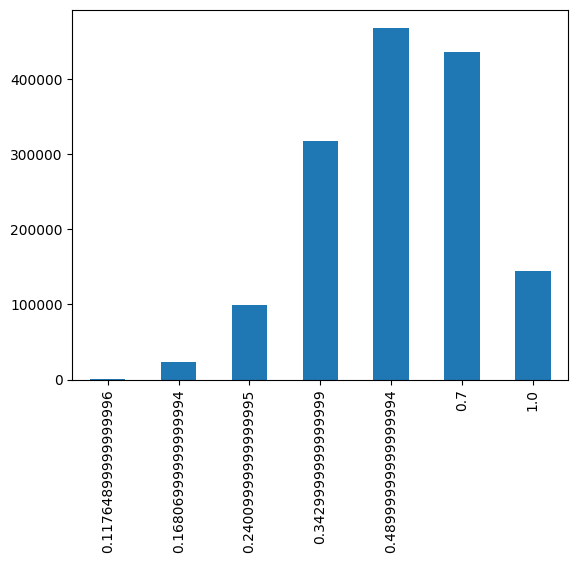

In [46]:
min_prob_unchanged.value_counts().sort_index().plot.bar()

In [47]:
min_prob_unchanged.describe()

count    1.490395e+06
mean     5.481160e-01
std      2.126908e-01
min      1.176490e-01
25%      3.430000e-01
50%      4.900000e-01
75%      7.000000e-01
max      1.000000e+00
dtype: float64

In [52]:
(first_names_ocr_map.str.strip() == first_names_ocr_map).all()

True

# Gaah! Same random seed in all rows!

The number of strings with 0 tokens (prob unchanged = 1) is 145066, which is **exactly the same number of strings that were unchanged in the .map version!!** This must be because I passed a constant random seed of 12, which got used in *all rows*, so if this seed's first random number was < 0.3, then that guarantees that **every string with an OCR token will receive noise.**

In [60]:
min_prob_unchanged.value_counts().sort_index()

0.117649       520
0.168070     22708
0.240100     98987
0.343000    318089
0.490000    468682
0.700000    436343
1.000000    145066
dtype: int64

In [58]:
1*145066 + .7*145066

246612.2

# Try again, but see if using a Generator instead of a constant seed will actually make the rows independent

In [78]:
%timeit rng = np.random.default_rng(12)

17.2 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [62]:
rng = np.random.default_rng(12)
%time first_names_ocr_map2 = first_names.map(lambda s: corruption.ocr_corrupt(s, prob, rng))
first_names_ocr_map2

CPU times: user 23.2 s, sys: 29.5 ms, total: 23.2 s
Wall time: 23.2 s


0            Meqan
1             L:Iv
2            Lex'l
3          Chelsev
4          Arnanda
            ...   
1490390       Joe1
1490391    4dalynn
1490392      Adnel
1490393    Pa:slev
1490394       Mila
Name: first_name, Length: 1490395, dtype: object

In [64]:
(first_names_ocr_map2 == first_names_ocr_map).sum()

340802

In [65]:
(first_names_ocr_map2 == first_names).sum()

707679

# Copy the function here and remove the `isinstance` check to handle Series just to make sure that's not causing any funny business

In [76]:
def ocr_corrupt(truth, corrupted_pr, random_state=None):
    """
    # Algorithm sketch

    For each token decide if it is OCRed correctly, and if it is not, decide how it goes wrong.

    Since there are tokens of length 1, 2, and 3, how to handle?
    I guess I can start with threes, then twos, then ones, for each location in a string.
    """
    rng = np.random.default_rng(random_state)
    err = ''
    i = 0
    while i < len(truth):
        error_introduced = False
        for token_length in [3,2,1]:
            token = truth[i:(i+token_length)]
            if token in corruption.ocr_error_dict and not error_introduced:
                if rng.uniform() < corrupted_pr:
                    err += rng.choice(corruption.ocr_error_dict[token])
                    i += token_length
                    error_introduced = True
        if not error_introduced:
            err += truth[i:(i+1)]
            i += 1
    return err

In [77]:
rng = np.random.default_rng(12)
%time first_names_ocr_map3 = first_names.map(lambda s: ocr_corrupt(s, prob, rng))
first_names_ocr_map3

CPU times: user 23.7 s, sys: 61.6 ms, total: 23.8 s
Wall time: 23.8 s


0            Meqan
1             L:Iv
2            Lex'l
3          Chelsev
4          Arnanda
            ...   
1490390       Joe1
1490391    4dalynn
1490392      Adnel
1490393    Pa:slev
1490394       Mila
Name: first_name, Length: 1490395, dtype: object

In [79]:
(first_names_ocr_map2 == first_names_ocr_map3).all()

True

# Check the vectorized and np.vectorized versions again using a Generator instead of a constant seed

Darn. My vectorized version is actually 2.6s *slower* than just using `.map`.

In [70]:
rng = np.random.default_rng(12)
%time first_names_ocr2 = corruption.ocr_corrupt(first_names, prob, rng)
first_names_ocr2

CPU times: user 25.1 s, sys: 1.13 s, total: 26.2 s
Wall time: 26.2 s


0            Megan
1             L:ly
2             Lex:
3          Che1sey
4           4manda
            ...   
1490390       Joel
1490391    Adalynn
1490392     Adniel
1490393    PaisJev
1490394       Mila
Name: first_name, Length: 1490395, dtype: object

In [72]:
(first_names_ocr2 == first_names_ocr).all()

True

In [80]:
rng = np.random.default_rng(12)
%time first_names_ocr_vec2 = np.vectorize(ocr_corrupt)(first_names, prob, rng)
first_names_ocr_vec2

CPU times: user 23.6 s, sys: 101 ms, total: 23.7 s
Wall time: 23.6 s


array(['Meqan', 'L:1v', "Lex'l", ..., 'Adnel', 'Pa:slev', 'Mila'],
      dtype='<U15')

In [81]:
pd.Series(first_names_ocr_vec2)

0            Meqan
1             L:1v
2            Lex'l
3          CbeIsey
4          Arnanda
            ...   
1490390       Joe1
1490391    4dalynn
1490392      Adnel
1490393    Pa:slev
1490394       Mila
Length: 1490395, dtype: object

In [83]:
(first_names_ocr_map2 == first_names_ocr_vec2)

0           True
1          False
2           True
3          False
4           True
           ...  
1490390     True
1490391     True
1490392     True
1490393     True
1490394     True
Name: first_name, Length: 1490395, dtype: bool

In [84]:
(first_names_ocr_map2 == first_names_ocr_vec2).sum()

1490322

In [85]:
(first_names == first_names_ocr_vec2).sum()

707676

# What happens if I just vectorize the function by calling itself recursively using .map?'

Well, that works -- it just added 1 second to the runtime for some reason. Maybe it would be more efficient to implement this using an inner function to avoid making multiple calls to `isinstance` and `.default_rng`.

In [86]:
def ocr_corrupt_rec(truth, corrupted_pr, random_state=None):
    """
    # Algorithm sketch

    For each token decide if it is OCRed correctly, and if it is not, decide how it goes wrong.

    Since there are tokens of length 1, 2, and 3, how to handle?
    I guess I can start with threes, then twos, then ones, for each location in a string.
    """
    if isinstance(truth, pd.Series):
        rng = np.random.default_rng(random_state)
        err = truth.map(lambda s: ocr_corrupt_rec(s, corrupted_pr, rng))
    else:
        rng = np.random.default_rng(random_state)
        err = ''
        i = 0
        while i < len(truth):
            error_introduced = False
            for token_length in [3,2,1]:
                token = truth[i:(i+token_length)]
                if token in corruption.ocr_error_dict and not error_introduced:
                    if rng.uniform() < corrupted_pr:
                        err += rng.choice(corruption.ocr_error_dict[token])
                        i += token_length
                        error_introduced = True
            if not error_introduced:
                err += truth[i:(i+1)]
                i += 1
    return err

In [87]:
rng = np.random.default_rng(12)
%time first_names_ocr_rec = ocr_corrupt_rec(first_names, prob, rng)
first_names_ocr_rec

CPU times: user 24.6 s, sys: 98.3 ms, total: 24.7 s
Wall time: 24.6 s


0            Meqan
1             L:Iv
2            Lex'l
3          Chelsev
4          Arnanda
            ...   
1490390       Joe1
1490391    4dalynn
1490392      Adnel
1490393    Pa:slev
1490394       Mila
Name: first_name, Length: 1490395, dtype: object

In [92]:
(first_names_ocr_rec == first_names_ocr_map2).all()

True

# Ha! Using an inner function *shaved* 1 second off the runtime

In [99]:
def ocr_corrupt_rec2(truth, corrupted_pr, random_state=None):
    """
    # Algorithm sketch

    For each token decide if it is OCRed correctly, and if it is not, decide how it goes wrong.

    Since there are tokens of length 1, 2, and 3, how to handle?
    I guess I can start with threes, then twos, then ones, for each location in a string.
    """
    def ocr_corrupt_str(truth, corrupted_pr, random_state):
        err = ''
        i = 0
        while i < len(truth):
            error_introduced = False
            for token_length in [3,2,1]:
                token = truth[i:(i+token_length)]
                if token in corruption.ocr_error_dict and not error_introduced:
                    if rng.uniform() < corrupted_pr:
                        err += rng.choice(corruption.ocr_error_dict[token])
                        i += token_length
                        error_introduced = True
            if not error_introduced:
                err += truth[i:(i+1)]
                i += 1
        return err
    
    rng = np.random.default_rng(random_state)
    if isinstance(truth, pd.Series):
        err = truth.map(lambda s: ocr_corrupt_str(s, corrupted_pr, rng))
    else:
        err = ocr_corrupt_str(truth, corrupted_pr, rng)
    return err


In [94]:
rng = np.random.default_rng(12)
%time first_names_ocr_rec2 = ocr_corrupt_rec2(first_names, prob, rng)
first_names_ocr_rec2

CPU times: user 22.7 s, sys: 61 ms, total: 22.8 s
Wall time: 22.8 s


0            Meqan
1             L:Iv
2            Lex'l
3          Chelsev
4          Arnanda
            ...   
1490390       Joe1
1490391    4dalynn
1490392      Adnel
1490393    Pa:slev
1490394       Mila
Name: first_name, Length: 1490395, dtype: object

In [95]:
(first_names_ocr_rec2 == first_names_ocr_map2).all()

True

In [96]:
corruption.ocr_error_dict

{'0': ['o', 'O'],
 '1': ['|'],
 '12': ['R'],
 '13': ['B'],
 '17': ['n'],
 '1<': ['k'],
 '1>': ['b'],
 '2': ['Z', 'z'],
 '5': ['S', 's'],
 '6': ['G'],
 'A': ['4'],
 'B': ['8'],
 'D': ['O'],
 'E': ['F'],
 'F': ['P'],
 'I-I': ['H'],
 'IJ': ['U'],
 'LI': ['U'],
 'Q': ['O'],
 'U': ['V'],
 'Y': ['V'],
 'cl': ['d'],
 'g': ['9', 'q'],
 'h': ['b'],
 'i': ["'l", ':'],
 'iii': ['m'],
 'j': ['i'],
 'k': ['lc'],
 'l': ['J', '1', 'I', '|'],
 'l<': ['k'],
 'l>': ['b'],
 'lJ': ['U'],
 'lo': ['b'],
 'm': ['n', 'rn'],
 'q': ['9', '4'],
 'ri': ['n'],
 'u': ['v'],
 'w': ['vv'],
 'y': ['v']}

In [100]:
rng = np.random.default_rng(12)
%time ocr_corrupt_rec2('1l'.join(corruption.ocr_error_dict.keys()), prob, rng)

CPU times: user 1.71 ms, sys: 78 µs, total: 1.78 ms
Wall time: 1.41 ms


"O||1|lR1lB1I171lk|l1>1121l5|l61|A|l81lD|lE1lF1lI-I|JIJ1lLI1lO1lU1lY|lc|1lg|lh|1'l1l'lii1lj|llc11l1ll<1lb|JU|lJo1lm1l411r'l|Iv1lw|ly"